# WIN, DRAW, LOSE VISUALIZATION
---

## Initial Setup and Version Check

This part accomplishes two primary tasks:

1. **Running the `vizFunc.py` Script**: This script is presumed to contain important functions and configurations required for data visualization throughout this notebook.

2. **Displaying Version Information**: It's crucial to document the versions of Python and key libraries _(NumPy, pandas, matplotlib)_ used in this analysis. This information aids in ensuring compatibility and ease of replication in different environments.


In [1]:
%run vizFunc.py

# for referencing
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))

Python: 3.11.5
NumPy: 1.24.3
pandas: 2.0.3
matplotlib: 3.7.2


---
### SQL Query

SQL query performs an aggregation, focusing on the duration of different match outcomes (win, draw, loss) for each team:

1. **Events Processing**: In etl.ipynb, I scrape event data and insert into event_stg -a table in MySQL db. The `events` CTE filters and processes match events, primarily focusing on goals and half starts/ends.

2. **Goal Impact**: In `scored_goals`, each goal's impact on the home and away teams is determined.

3. **Cumulative Score Calculation**: The `cumulative_score` CTE calculates the running score difference for each match.

4. **Match Status Determination**: The `match_status` CTE determines the status of the match (win, draw, loss) based on the score difference.

5. **Time Difference Calculation**: The `time_diff` CTE computes the time difference between events.

6. **Home & Away**: The `home_duration_split` and `away_duration_split` CTEs split the durations of _wins_, _draws_, and _losses_ for *home* and *away* teams, respectively.

7. **Final Aggregation and Output**: The final SELECT statement aggregates these durations and match counts for each team, presenting a view of each team's performance in terms of time spent in winning, drawing, or losing positions.

In [2]:
# read query from .sql file
with open('data/query/wdl_durations.sql') as inserts:
    wdl_q = inserts.read()
print(wdl_q)


WITH events AS (
	SELECT 
		e.match_id,
		e.type_name,
		e.player_name,
		CASE WHEN type_name NOT IN ('Half Start', 'Half End') THEN e.team_name END AS team_name,
		e.period,
		e.timestamp,
		e.minute,
		e.second,
		e.duration, 
		ROW_NUMBER() OVER (PARTITION BY e.match_id) as match_rnk,
		ADDTIME(STR_TO_DATE(timestamp, '%H:%i:%s.%f'), SEC_TO_TIME(e.duration)) as new_timestamp,
		m.home_team_name,
		m.away_team_name
	FROM event_stg e
	JOIN `match` m
	ON e.match_id = m.match_id
	WHERE
		e.outcome_name = 'Goal'
		OR e.type_name = 'Half Start' AND (e.team_name != e.possession_team_name)
		OR (e.type_name = 'Half End') AND (e.team_name != e.possession_team_name)
	ORDER BY 
		e.match_id DESC, 
		e.period, 
		e.timestamp
	),
scored_goals as (
	SELECT e.*, 
		CASE
			WHEN team_name = home_team_name THEN 1
			WHEN team_name = away_team_name THEN -1
			ELSE 0
		END AS goal_effect
	FROM EVENTS e
	),
cumulative_score AS (
    SELECT
        s.*,
        -- Her maç ve yarı için kümülatif skor far

---

In [3]:
# connect, read query, rename columns, define colors
conn = mysql_connect()
wdl  = pd.read_sql_query(wdl_q, conn)[["team_name","win_duration","draw_duration","lose_duration"]]
wdl = wdl.rename(columns={"win_duration":"Win","draw_duration":"Draw","lose_duration":"Lose"})
colors = ['#4EFF83', '#807e7f' , '#BA495C'] #win,draw,lose
wdl

,team_name,Win,Draw,Lose
0,Leicester City,83749.0,107344.0,28938.0
1,Arsenal,78148.0,111456.0,28765.0
2,Tottenham Hotspur,75784.0,120033.0,22817.0
3,West Ham United,74299.0,94464.0,52596.0
4,Southampton,71785.0,100444.0,47455.0
5,Manchester City,71134.0,100740.0,46925.0
6,Chelsea,68543.0,101871.0,50930.0
7,Manchester United,63020.0,124359.0,30862.0
8,Liverpool,61632.0,115019.0,43235.0
9,Stoke City,60090.0,101335.0,58314.0


## Code block for visualisation
---
#### As a next step, I need to convert this into an object or a definition that returns the whole thing.

Text(1, 0.7, 'Murat Seyhan')

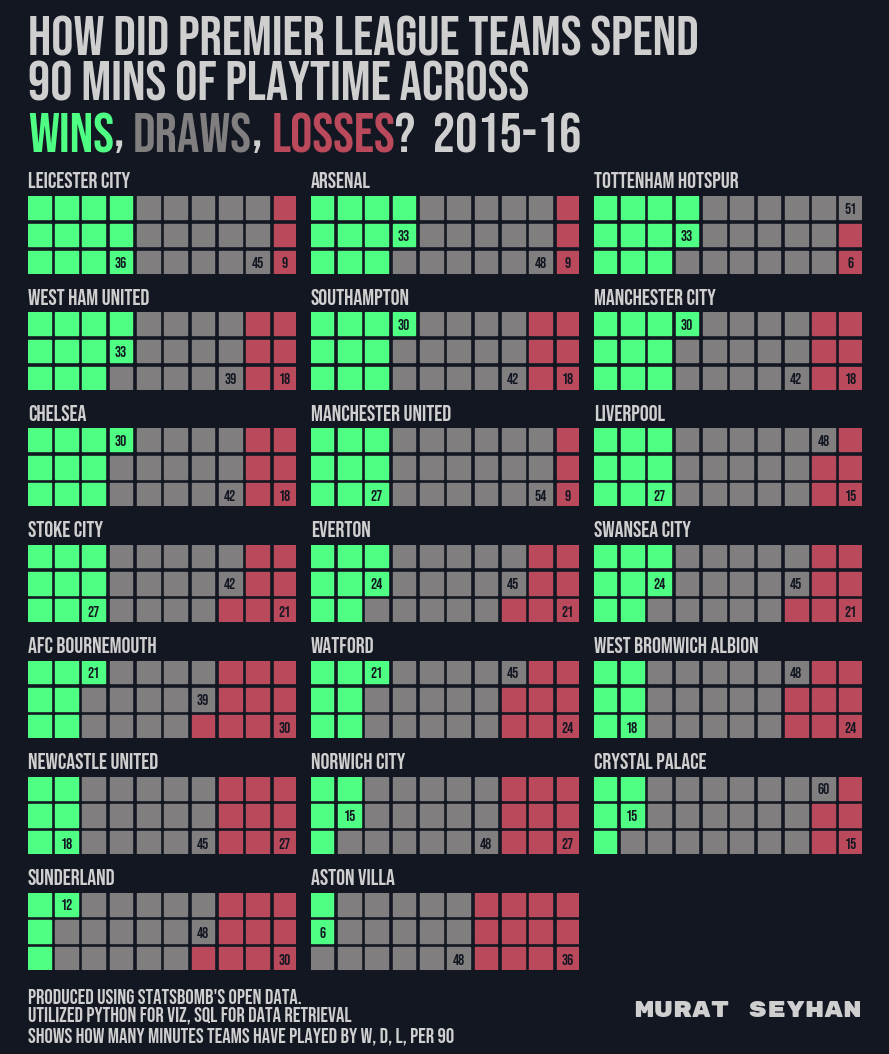

In [4]:
num_teams = len(wdl) # number of teams for grid
num_cols = 3  # how many charts per row you want
facecolor = '#131722'
fontColor = '#cfcfcf'

# define fonts
captionFm = FontManager(url=config["fonts"]["bebas_neue"]) 
endnoteFm = FontManager(url=config["fonts"]["rubik"])

fig_scale = .5 # determine the fig scale

# arbitrarily set, I decided every cols should be 6 times the fig_scale,
# every row height should be 3 times the fig_scale, I think it's satisfying
fig_width = num_cols * 6 * fig_scale 
fig_height_per_row = 3 * fig_scale

num_rows = (num_teams + num_cols - 1) // num_cols  # calculate required number of rows

# figure/ gridspec creation: 
# left/right margin space, space for endnote & title, the rest is undefined
fig = plt.figure(figsize=(fig_width, num_rows*fig_height_per_row))
gs = fig.add_gridspec(3, 3,
                      width_ratios=[.01, 3, .01], # define width_ratios
                      height_ratios=[1.1, 6, .2] # define height ratios
                      )  # 3x3 grid, the main chart area is in the middle, [1,1]


# define subplots as axes and name them accordingly, set facecolor for each axes & figure
fig.set_facecolor(facecolor)
# title
title_ax = fig.add_subplot(gs[0, 1])  # for example, in the middle cell
title_ax.set_facecolor(facecolor)
title_ax.set_axis_off()

# endnote
endnote_ax = fig.add_subplot(gs[2, 1])  # for example, in the middle cell
endnote_ax.set_facecolor(facecolor)
endnote_ax.set_axis_off()

#left margin
leftmargin_ax = fig.add_subplot(gs[1, 0])
leftmargin_ax.set_facecolor(facecolor)
leftmargin_ax.set_axis_off()

# right margin
rightmargin_ax = fig.add_subplot(gs[1, 2])
rightmargin_ax.set_facecolor(facecolor)
rightmargin_ax.set_axis_off()

# chart
chart_ax = fig.add_subplot(gs[1, 1])
chart_ax.set_facecolor(facecolor)
chart_ax.set_axis_off()


subgrid_cols = 3  # determine how many charts per row you want
subgrid_rows = math.ceil(num_teams / subgrid_cols)  # calculate rows needed

# create sub gridspecs, I have 4 main axes/subplots in my gridspec,
# for title ax, it needs to be divided into a changing amount of grids
subgs = GridSpecFromSubplotSpec(subgrid_rows, 
                                subgrid_cols, 
                                subplot_spec=gs[1, 1], # refers to title_ax in first gridspec
                                wspace=None, # adjust
                                hspace=0.3, # adjust
                                )

# iterate for each team in the sql output: all teams in the league with win, draw, lose durations

for i, row in wdl.iterrows():
    team_name = row.iloc[0] # set team name
    values = row.iloc[1:].values.tolist() # set values
    rows = 3 # determine the rows in waffle
    columns = 10 # determine the cols in waffle
    how_far_2_90 = 90 / (rows * columns)

    # calculate the position in the grid
    row_index = i // subgrid_cols
    col_index = i % subgrid_cols
    
    # create subplots in the grid
    if row_index < subgrid_rows:
        subax = fig.add_subplot(subgs[row_index, col_index], # add subplot in sub-gridspec based on position in the grid,
                                aspect='equal' # equal aspect looks better and easier to apply, not flexible unfortunately
                                )

    # create a waffle chart
    Waffle.make_waffle(
        ax=subax,
        rows=rows,
        columns=columns,
        values=values,
        colors=colors,
        starting_location='NW',
        rounding_rule='ceil',
        w_pad=10,
        h_pad=10,
        title={'label': team_name, 
               'loc': 'left', 
               'color': fontColor, 
               'fontweight': 'bold', 
               'fontproperties': captionFm.prop, 
               'fontsize': (fig_width / fig_height_per_row) +(fig_scale*20)} # just found the most suitable calculation for scalable fontsize by trial and error :D
    )
    # extract rectangle coordinates and convert colors to hex
    rectangles = [artist for artist in subax.get_children() if isinstance(artist, Rectangle)]
    coords_and_hex_colors = [
        (rect.get_x(), rect.get_y(), to_hex(rect.get_facecolor()).lower()) for rect in rectangles
    ]

    # find last occurrences of each color
    unique_color_coords = {}
    for x_coord, y_coord, color in reversed(coords_and_hex_colors):
        if color != '#ffffff' and color not in unique_color_coords:
            unique_color_coords[color] = (x_coord, y_coord)

    # calculate color counts
    color_counts = {}
    for _, _, color in coords_and_hex_colors:
        color_counts[color] = color_counts.get(color, 0) + 1

    # calculate the block width and height
    if rectangles:
        block_width = rectangles[0].get_width()
        block_height = rectangles[0].get_height()

    # annotate the counts for each color
    for color, (x_coord, y_coord) in unique_color_coords.items():
        if color in color_counts:
            count = color_counts[color]
            # adjust coordinates to center the text on the block
            x_coord_centered = x_coord + block_width / 2
            y_coord_centered = y_coord + block_height / 2
            subax.text(x_coord_centered, y_coord_centered, 
                       str(int(count*how_far_2_90)), 
                       fontsize= (fig_width / fig_height_per_row) +(fig_scale*10), # just found the most suitable calculation for scalable fontsize by trial and error :D
                       ha='center', va='center', 
                       color= facecolor, # same as face color, looks rich
                       fontweight='bold',
                       fontproperties=captionFm.prop)

fig.tight_layout()
fig.subplots_adjust(left=None, right=None, wspace=None, hspace=None, bottom=None,top=None) # only for testing purposes

# title
ax_text(0, 0.5, 
        f'''How did Premier League teams spend\n90 mins of playtime across\n<wins>, <draws>, <losses>?  2015-16\n''', # SEASON NAME SHOULD BE PUT AUTOMATICALLY
    ax=title_ax,
    fontsize=40,
    va='center',
    ha='left',
    color = '#cfcfcf' ,
    weight='bold',
    fontproperties=captionFm.prop
    , highlight_textprops=[{"color": colors[0]},{"color": colors[1]},{"color": colors[2]}]
    , zorder = 5)

# endnote
endnote_ax.text(0, 0.7, '''Produced using StatsBomb's open data.\nUtilized Python for viz, SQL for data retrieval\nShows how many minutes teams have played by w, d, l, per 90''', color='#cfcfcf',
                    va='center', ha='left', fontsize=15,
                    fontproperties=captionFm.prop)

endnote_ax.text(1, 0.7, '''Murat Seyhan''', color='#cfcfcf',
                    va='bottom', ha='right', fontsize=16,
                    fontproperties=endnoteFm.prop)